A simple convolutional neural network using JAX

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from jax import jit
from jax.lax import conv_general_dilated, reduce_window
import matplotlib.pyplot as plt

In [2]:
# initializing the layers
def initialize_conv_layer(f, n_C_prev, n_C_new):
    weight_shape = (f, f, n_C_prev, n_C_new)
    bias_shape = (1, 1, 1, n_C_new)
    std = np.sqrt(2/(f*f*n_C_prev))
    W = jnp.array(np.random.randn(*weight_shape)*std)
    b = jnp.array(np.zeros(bias_shape))
    return W, b

def initialize_fc_layer(n_units, n_units_prev):
    # input should be (n_units_prev, 1)
    weight_shape = (n_units, n_units_prev)
    bias_shape = (n_units,)
    std = np.sqrt(2/n_units_prev)
    W = jnp.array(np.random.randn(*weight_shape) * std)
    b = jnp.array(np.zeros(bias_shape))
    return W, b

def initialize_batchnorm():
    gamma = jnp.array(np.random.randn())
    beta = jnp.array(np.random.randn())
    return gamma, beta

In [3]:
# architecture of model (hard-coded)
# CONV2D -> RELU ->  MAXPOOL -> CONV2D -> RELU -> MAXPOOL ->
# FLATTEN -> DENSE -> RELU -> DENSE (output, softmax)

def CONV_2D(input_img, W, b, stride, padding):
    if (padding == 0):
        padding_style = 'VALID'
    if (padding == 1):
        padding_style = 'SAME'
    # image has shape [n_H, n_W, n_C]
    out_img = conv_general_dilated(input_img[None,...], W, window_strides=(stride,stride), padding=padding_style, dimension_numbers=('NHWC', 'HWIO', 'NHWC'))[0,...] + b.reshape(-1)
    return out_img
@jit
def RELU(z):
    return jnp.maximum(0, z)

def MAXPOOL(input_img, f, stride, padding):
    if (padding == 0):
        padding_style = 'VALID'
    if (padding == 1):
        padding_style = 'SAME'
    out_img = reduce_window(input_img, init_value = -jnp.inf, computation=jax.lax.max, window_dimensions=(f, f, 1), window_strides=(stride, stride, 1), padding=padding_style)
    return out_img
@jit
def FLATTEN(x):
    return x.reshape(-1)
@jit
def DENSE(x, W, b):
    return jnp.dot(W,x) + b
@jit
def SOFTMAX(x):
    x_norm = (x-jnp.max(x))
    num = jnp.exp(x_norm)
    den = jnp.sum(num)
    return num/den
@jit
def BATCHNORM(x, gamma, beta):
    mu = x.mean()
    std = x.std()
    x_norm = (x - mu)/std
    x_out = gamma * x_norm + beta
    return x_out

In [4]:

def init_lenet_params(X):
    # X has shape (num_examples, n_H, n_W, n_C)
    C1_W, C1_b = initialize_conv_layer(f=5, n_C_prev = X.shape[-1], n_C_new = 20)
    C2_W, C2_b = initialize_conv_layer(f=3, n_C_prev = C1_W.shape[-1], n_C_new = 50)
    # forward pass to compute the dimensions of the fully-connected layer
    x1 = X[0, ...]*0
    c1 = CONV_2D(x1, C1_W, C1_b, stride=1, padding=0)
    a1 = RELU(c1)
    x2 = MAXPOOL(a1, f=2, stride=2, padding=0)
    c2 = CONV_2D(x2, C2_W, C2_b, stride=1, padding=0)
    a2 = RELU(c2)
    x3 = MAXPOOL(a2, f=2, stride=2, padding=0)
    x4 = FLATTEN(x3)
    FC1_W, FC1_b = initialize_fc_layer(n_units = 200, n_units_prev=x4.shape[0])
    FC2_W, FC2_b = initialize_fc_layer(n_units = 10, n_units_prev = 200)
    gamma1, beta1 = initialize_batchnorm()
    gamma2, beta2 = initialize_batchnorm()
    gamma3, beta3 = initialize_batchnorm()
    params = [C1_W, C1_b, C2_W, C2_b, FC1_W, FC1_b, FC2_W, FC2_b, gamma1, beta1, gamma2, beta2, gamma3, beta3]
    return params
@jit
def lenet_forward(x_i,  y_i, params):
    # X has shape (num_examples, n_H, n_W, n_C)
    # Y has shape (num_examples, output_label(one hot, one of 26))
    C1_W, C1_b, C2_W, C2_b, FC1_W, FC1_b, FC2_W, FC2_b, gamma1, beta1, gamma2, beta2, gamma3, beta3 = params
    # forward prop
    x1 = jnp.array(x_i)
    c1 = CONV_2D(x1, C1_W, C1_b, stride=1, padding=0)
    a1 = RELU(c1)
    a1 = BATCHNORM(a1, gamma1, beta1)
    x2 = MAXPOOL(a1, f=2, stride=2, padding=0)
    c2 = CONV_2D(x2, C2_W, C2_b, stride=1, padding=0)
    a2 = RELU(c2)
    a2 = BATCHNORM(a2, gamma2, beta2)
    x3 = MAXPOOL(a2, f=2, stride=2, padding=0)
    x4 = FLATTEN(x3)
    x5 = DENSE(x4, FC1_W, FC1_b)
    a5 = RELU(x5)
    a5 = BATCHNORM(a5, gamma3, beta3)
    x6 = DENSE(a5, FC2_W, FC2_b)
    output_i = SOFTMAX(x6)
    return output_i

# computing losses
@jit
def loss(params, X,Y):
    m = X.shape[0]
    Yhat = jax.vmap(lambda x, y: lenet_forward(x, y, params))(X,Y)
    loss_total = -jnp.sum(Y * jnp.log(Yhat))/m 
    return loss_total
@jit
def gradient_descent(params, X, Y, learning_rate, v):
    m = X.shape[0]
    gradients = jax.grad(loss)(params, X, Y)
    v_new = [0.9*v_i + 0.1*g for v_i, g in zip(v, gradients)]
    updated_params = [p - learning_rate * v_i for p, v_i in zip(params, v_new)]
    return updated_params, v

def train(X_train,y_train, num_train=100, learning_rate_0=0.01, val_set=(None,None)):
    X0 = X_train
    Y0 = y_train
    batch_size = 128
    num_batches = np.int64(np.floor(X0.shape[0]/batch_size))
    params = init_lenet_params(X0)
    v = [jnp.zeros_like(p) for p in params]
    losses_train = []
    losses_val = []
    for n in range(num_train):
        # batching
        p = np.random.permutation(X0.shape[0])
        X0 = X0[p, ...]
        Y0 = Y0[p, ...]
        for n_batch in range(num_batches):
            if (n_batch == num_batches - 1):
                batch_start = n_batch * batch_size
                batch_end = X0.shape[0]
            else:
                batch_start = n_batch * batch_size
                batch_end = (n_batch + 1)*batch_size
            X = X0[batch_start:batch_end, ...]
            Y = Y0[batch_start:batch_end, ...]
            learning_rate = learning_rate_0
            params, v = gradient_descent(params, X, Y, learning_rate, v)

        # compute losses and store them at specific intervals.
        if (n % 50 == 0):
            X_val, y_val = val_set
            val_loss = 0.0
            train_loss = 0.0
            loss_batch_size = 128
            n_batch = 0
            # compute loss on first batch of permuted X_train, y_train
            batch_start = n_batch * loss_batch_size
            batch_end = (n_batch + 1)*loss_batch_size
            q = np.random.permutation(X_val.shape[0])
            Xt = X_train[q,...][batch_start:batch_end, ...]
            Yt = y_train[q,...][batch_start:batch_end, ...]
            train_loss = loss(params, Xt, Yt)

            # compute loss for validation set on first batch of permuted X_val, y_val
            r = np.random.permutation(X_val.shape[0])
            Xv = X_val[r,...][batch_start:batch_end, ...]
            Yv = y_val[r,...][batch_start:batch_end, ...]
            val_loss = loss(params, Xv, Yv)

            # save the losses
            losses_train.append(train_loss)
            losses_val.append(val_loss)
            
            print(f"training epoch: {n}, training loss:{train_loss}, validation loss: {val_loss}")
    losses = {"train": losses_train, "val": losses_val}

    final_parameters = {"C1_W": params[0],
                       "C1_b": params[1],
                       "C2_W": params[2],
                       "C2_b": params[3],
                       "FC1_W": params[4],
                       "FC1_b": params[5],
                       "FC2_W": params[6],
                       "FC2_b": params[7],
                       "gamma1": params[8],
                       "beta1": params[9],
                       "gamma2": params[10],
                       "beta2": params[11],
                       "gamma3": params[12],
                       "beta3": params[13]}
    return losses, final_parameters


In [5]:
import tensorflow as tf
def load_mnist_data():
    def OneHotEncoder(labels, num_classes = 10):
        return np.eye(num_classes)[labels]
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train/ 255.0
    X_train = X_train.reshape(-1,28, 28, 1)
    y_train = OneHotEncoder(y_train, 10)
    X_test = X_test / 255.0
    X_test = X_test.reshape(-1,28, 28, 1)
    y_test = OneHotEncoder(y_test, 10)
    return X_train, y_train, X_test, y_test


2024-09-04 02:17:05.026302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 02:17:05.040618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 02:17:05.044647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
X_train, y_train, X_test, y_test = load_mnist_data()

In [7]:
losses, final_parameters = train(X_train,y_train, learning_rate_0=1e-4, num_train=5_000,
                                val_set = (X_test, y_test))

training epoch: 0, training loss:2.553757905960083, validation loss: 2.553269863128662
training epoch: 50, training loss:1.4796733856201172, validation loss: 1.4987738132476807
training epoch: 100, training loss:0.5801301598548889, validation loss: 0.6342469453811646
training epoch: 150, training loss:0.6050052642822266, validation loss: 0.44593164324760437
training epoch: 200, training loss:0.3618471324443817, validation loss: 0.35511961579322815
training epoch: 250, training loss:0.24909400939941406, validation loss: 0.28732889890670776
training epoch: 300, training loss:0.21871016919612885, validation loss: 0.332882821559906
training epoch: 350, training loss:0.19280177354812622, validation loss: 0.27293625473976135
training epoch: 400, training loss:0.1869894564151764, validation loss: 0.20879748463630676
training epoch: 450, training loss:0.16423285007476807, validation loss: 0.23829656839370728
training epoch: 500, training loss:0.24191021919250488, validation loss: 0.27345037460

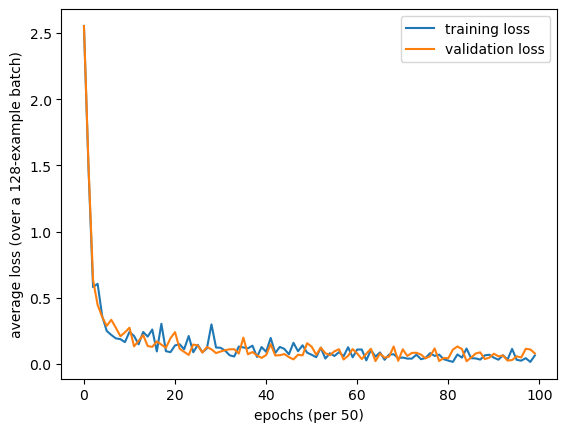

In [10]:
plt.plot(losses['train'], label = 'training loss')
plt.plot(losses['val'], label='validation loss')
plt.xlabel("epochs (per 50)")
plt.ylabel("average loss (over a 128-example batch)")
plt.legend()
plt.show()